# Active Learning through Dataset Reduction: Methods Comparison

**Author**: Benjamin Urben<br>
**Email**: burben@student.ethz.ch / benjamin.urben@hotmail.ch<br>
**Context**: Master Thesis on "Use of Machine Learning in the Design and Analysis for Steel Connections"<br>
**Institution**: ETH Zürich, Institute of Structural Engineering (IBK)

**Description**:

Simulations to establish best learning function, by reducing the dataset and strategically incrementing it, evaluating the DNN alongside.

**Dependencies**: 
- `DNN.py`
- `AL.py`
- `Datareader.py`
- `Settings.py`
- `Plot_Functions.py`

## Setup

In [1]:
import os
import importlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from scipy.stats import norm
from scipy import stats

import torch
import torch.nn as nn
import torch.optim as optim

from Settings import Directory, Plotting_Parameters

import DataReader
importlib.reload(DataReader)
from DataReader import DataReader

import DNN
importlib.reload(DNN)
from DNN import DNN

import ActiveLearning
importlib.reload(ActiveLearning)
from ActiveLearning import ActiveLearning as AL

import warnings
warnings.filterwarnings('ignore')

## Directory

In [2]:
directory = Directory()
plot_params = Plotting_Parameters()

model_name = "DNN_Model_Reduced"

DATA_FILE = r"Data\Knee_Connection_Output_red.csv"
MODEL_SAVE_PATH = os.path.join("Saved Models", model_name)
MODEL_SAVE_FILE = os.path.join(MODEL_SAVE_PATH, f"{model_name}.pth")

Root Directory set to:  c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks


In [38]:
# Disable if plots should not be saved
plot_params.save_figures = True

## Load Model and Data

In [ ]:
model_benchmark = torch.load(MODEL_SAVE_FILE)

for line in model_benchmark.config:
    print(line+":", model_benchmark.config[line])

In [ ]:
datareader = DataReader()
df_full = datareader.load(model_benchmark.data['data_file_name'])
df = df_full.iloc[model_benchmark.data['data_indeces']]

print('Data Shape:', df.shape)

Root Directory set to:  c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks
Knee_Connection_Output_red.csv
Knee_parallel_I_Off0_Output_red_Q1.xlsx
Knee_parallel_I_Off0_Output_red_Q4.xlsx
Knee_parallel_I_Output_Q1.xlsx
Knee_parallel_I_Output_red_Q4.xlsx
Knee_perpendicular_n.stiff_Off0_Output_red_Q1.xlsx
Knee_perpendicular_n.stiff_Off0_Output_red_Q4.xlsx
Knee_perpendicular_n.stiff_Output_red_Q1.xlsx
Knee_perpendicular_n.stiff_Output_red_Q4.xlsx
Knee_widener_I_Output_Off0_red_Q1.xlsx
Knee_widener_I_Output_red_Q1.xlsx
Knee_Connection_Output_red.csv: (714385, 53)
Data Shape: (23518, 53)


## Active Learning

In [5]:
model = DNN()

# Copy the model parameters from the benchmark model to the test model
for line in model_benchmark.config:
    model.config[line] = model_benchmark.config[line]

for line in model_benchmark.data:
    model.data[line] = model_benchmark.data[line]

model.features = model_benchmark.features
model.target = model_benchmark.target

# Adjust epochs and learning rate
model.config['epochs'] = 50
model.config['learning_rate'] = 0.01
model.config['dropout_prob'] = 0.00

# Load data
df = df_full.iloc[model_benchmark.data['data_indeces']]

# Prepare test model
model.prepare_data(df)
model.build()

Number of training samples: 18814
Number of validation samples: 2352
Number of testing samples: 2352


In [6]:
activeLearning = AL(model = model,
              method = None,
              df = df,
              init_strategy='latin_hypercube',
              n_init_samples=500,
              max_iterations=20,
              batch_size=200
            )

activeLearning.config['stopping_criteria'] = None
activeLearning.config['stopping_threshold'] = 1.0
activeLearning.config['selection_mode'] = 'fixed_batch'

iterations_per_method = 3

** Available Methods **
error_based
minimize_MCD_uncertainty
minimize_MCD_uncertainty_and_error
random_sampling
cluster_based
latin_hypercube
** Available Initiation Methods **
kmeans
latin_hypercube
max_min_distance
random_sampling


## Method Comparison

In [ ]:
perf_comp_iter = {'method':[]}

for performance_metric in activeLearning.performance_template:
    perf_comp_iter[performance_metric] = []

In [ ]:
methods_to_test = activeLearning.methods_available
methods_to_test = list(reversed(methods_to_test))
methods_to_test

In [30]:
model_sim = copy.deepcopy(model)

model_sim.config['seed'] = np.random.randint(0,10000)
activeLearning.config['seed'] = np.random.randint(0,10000)

model_sim.dropout.p = 0.1

activeLearning.df_initial = activeLearning.select_initial_data()

model_sim.prepare_data(df)
model_sim.build()

for method in methods_to_test:
    print(f"**** Current method: {method} ****")
    activeLearning.model = copy.deepcopy(model_sim)

    activeLearning.method = method
    performance = activeLearning.trigger_active_learning()

    perf_comp_iter['method'].append(method)
    for metric,score in performance.items():
        perf_comp_iter[metric].append(score)

Number of training samples: 18814
Number of validation samples: 2352
Number of testing samples: 2352
**** Current method: latin_hypercube ****
Initial R² Score: 0.9182865992188454
Iteration 1: Training with 500 samples
    R² Score: 0.9762056339532137
Iteration 2: Training with 700 samples
    R² Score: 0.9826880171895027
Iteration 3: Training with 900 samples
    R² Score: 0.9913677200675011
Iteration 4: Training with 1100 samples
    R² Score: 0.988799411803484
Iteration 5: Training with 1300 samples
    R² Score: 0.9932883251458406
Iteration 6: Training with 1500 samples
    R² Score: 0.9916449980810285
Iteration 7: Training with 1700 samples
    R² Score: 0.9822727646678686
Iteration 8: Training with 1900 samples
    R² Score: 0.992336648516357
Iteration 9: Training with 2100 samples
    R² Score: 0.9960794933140278
Iteration 10: Training with 2300 samples
    R² Score: 0.9924722034484148
Iteration 11: Training with 2500 samples
    R² Score: 0.917357362806797
Iteration 12: Trainin

In [38]:
df_perf_comp_iter = pd.DataFrame(perf_comp_iter)

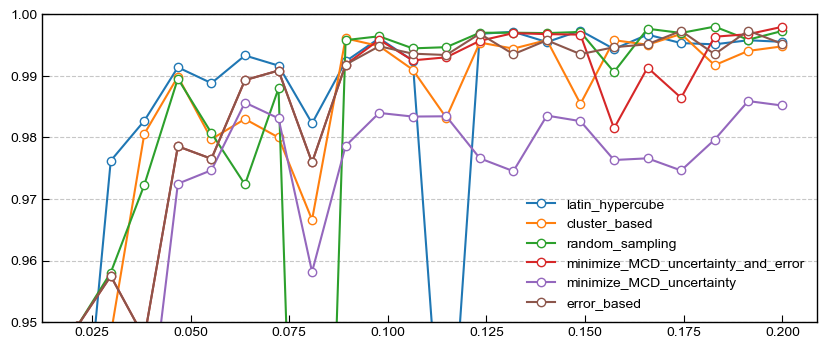

In [51]:
fig, ax = plt.subplots(figsize=(10, 4))

for i,row in df_perf_comp_iter.iterrows():
    ax.plot(row['data_ratio'], row['R2'],
            marker='o', 
            c=plot_params.colors[i],
            markerfacecolor='white',
            label=row['method'],)
    
plt.legend()
plt.ylim([0.95,1])

plt.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.show()

### Train Models with selected data

In [59]:
models = []

for i, row in df_perf_comp_iter.iterrows():
    model = DNN()
    model.config['epochs'] = 200
    model.config['learning_rate'] = 0.02
    model.config['dropout_prob'] = 0.00

    df = df_full.iloc[row['data_indeces'][-1]]
    model.prepare_data(df)
    model.build()
    model.train()
    
    models.append(model)

Number of training samples: 3760
Number of validation samples: 470
Number of testing samples: 470
Epoch 1/200, Train Loss: 0.044567, Val Loss: 0.009150
Epoch 2/200, Train Loss: 0.006168, Val Loss: 0.005065
Epoch 3/200, Train Loss: 0.004332, Val Loss: 0.004663
Epoch 4/200, Train Loss: 0.003646, Val Loss: 0.003894
Epoch 5/200, Train Loss: 0.003093, Val Loss: 0.003100
Epoch 6/200, Train Loss: 0.002646, Val Loss: 0.002564
Epoch 7/200, Train Loss: 0.002062, Val Loss: 0.002112
Epoch 8/200, Train Loss: 0.001680, Val Loss: 0.001869
Epoch 9/200, Train Loss: 0.001292, Val Loss: 0.001296
Epoch 10/200, Train Loss: 0.001019, Val Loss: 0.001373
Epoch 11/200, Train Loss: 0.000922, Val Loss: 0.000942
Epoch 12/200, Train Loss: 0.000759, Val Loss: 0.000931
Epoch 13/200, Train Loss: 0.000648, Val Loss: 0.001034
Epoch 14/200, Train Loss: 0.000623, Val Loss: 0.001190
Epoch 15/200, Train Loss: 0.000639, Val Loss: 0.000874
Epoch 16/200, Train Loss: 0.000477, Val Loss: 0.000615
Epoch 17/200, Train Loss: 0.000

In [ ]:
methods = df_perf_comp_iter['method'].values.tolist()
for i,model in enumerate(models):
    print(methods[i])
    model.dropout.p = 0.1
    performance_metrics = model.get_metrics()

    print(f"{methods[i]}: {performance_metrics['R2']}")

    y_preds, _ = model.evaluate()

    fig, ax = plt.subplots(figsize=(4, 4))
    
    ax.scatter(model.y_test, y_preds, s=10,
               edgecolors=plot_params.morecolors[0],
               facecolors=plot_params.morecolors[1],)

    plt.show()

## Methods Comparison Mean

In [ ]:
activeLearning = AL(model = model,
              method = None,
              df = df,
              init_strategy='latin_hypercube',
              n_init_samples=500,
              max_iterations=20,
              batch_size=200
            )

activeLearning.config['stopping_criteria'] = None
activeLearning.config['stopping_threshold'] = 1.0
activeLearning.config['selection_mode'] = 'fixed_batch'

iterations_per_method = 3

In [ ]:
perf_comp_iter = {'method':[], 'iteration':[]}

for performance_metric in activeLearning.performance_template:
    perf_comp_iter[performance_metric] = []

In [ ]:
methods_to_test = activeLearning.methods_available
methods_to_test = list(reversed(methods_to_test))
methods_to_test

In [20]:
for i in range(iterations_per_method):
    print(f"** Iteration {i+1}/{iterations_per_method} **")

    model_sim = copy.deepcopy(model)
    model_sim.config['seed'] = np.random.randint(0,10000)
    activeLearning.config['seed'] = np.random.randint(0,10000)
    activeLearning.df_initial = activeLearning.select_initial_data()
    
    model_sim.prepare_data(df)
    model_sim.build()

    for method in methods_to_test:
        print(f"**** Current method: {method} ****")
        activeLearning.model = copy.deepcopy(model_sim)

        activeLearning.method = method
        performance = activeLearning.trigger_active_learning()

        perf_comp_iter['method'].append(method)
        perf_comp_iter['iteration'].append(i)
        for metric,score in performance.items():
            perf_comp_iter[metric].append(score)

** Iteration 1/3 **
Number of training samples: 18814
Number of validation samples: 2352
Number of testing samples: 2352
**** Current method: latin_hypercube ****
Initial R² Score: 0.9317255094647408
Iteration 1: Training with 500 samples
    R² Score: 0.9663078710436821
Iteration 2: Training with 600 samples
    R² Score: 0.9782696589827538
Iteration 3: Training with 700 samples
    R² Score: 0.987640019506216
Iteration 4: Training with 800 samples
    R² Score: 0.9804060682654381
Iteration 5: Training with 900 samples
    R² Score: 0.988152401521802
Iteration 6: Training with 1000 samples
    R² Score: 0.9866836005821824
Iteration 7: Training with 1100 samples
    R² Score: 0.9882340002804995
Iteration 8: Training with 1200 samples
    R² Score: 0.9903692062944174
Iteration 9: Training with 1300 samples
    R² Score: 0.9690935853868723
Iteration 10: Training with 1400 samples
    R² Score: 0.990736361593008
Iteration 11: Training with 1500 samples
    R² Score: 0.989410113543272
Iter

In [21]:
df_perf_comp_iter = pd.DataFrame(perf_comp_iter)
df_perf_comp_iter.to_pickle("AL_methods_performance_comparison.pkl")

In [ ]:
df_perf_comp_iter = pd.read_pickle(r"Saved Variables/AL_methods_performance_comparison.pkl")

In [9]:
df_perf_comp_iter['method']

0                        latin_hypercube
1                          cluster_based
2                        random_sampling
3     minimize_MCD_uncertainty_and_error
4               minimize_MCD_uncertainty
5                            error_based
6                        latin_hypercube
7                          cluster_based
8                        random_sampling
9     minimize_MCD_uncertainty_and_error
10              minimize_MCD_uncertainty
11                           error_based
12                       latin_hypercube
13                         cluster_based
14                       random_sampling
15    minimize_MCD_uncertainty_and_error
16              minimize_MCD_uncertainty
17                           error_based
Name: method, dtype: object

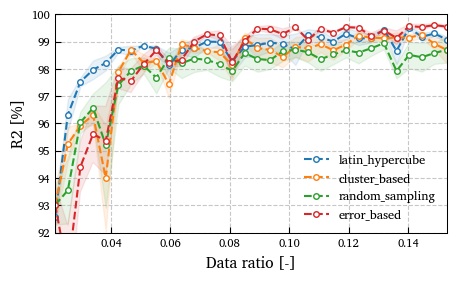

In [42]:
fig, ax = plt.subplots(figsize=plot_params.get_figsize(0.75))

for j,method in enumerate(['latin_hypercube','cluster_based','random_sampling','error_based']):
    df_method = df_perf_comp_iter[df_perf_comp_iter['method']==method]

    R2_values = np.column_stack(df_method['R2'].values)
    data_ratio = np.column_stack(df_method['data_ratio'].values)

    R2_mean_values = R2_values.mean(axis=1)*100
    R2_std_values = R2_values.std(axis=1)*100

    for i,(mean, std, label) in enumerate(zip([R2_mean_values],
                                              [R2_std_values],
                                              ['R2'])):
        ax.plot(data_ratio[:,0],
                      mean,
                    color=plot_params.morecolors[2*j],
                    marker='o',
                    markersize=4,
                    linestyle='--',
                    markerfacecolor='white',
                    markeredgecolor=plot_params.morecolors[2*j],
                    label=method,
                    zorder=2)
        
        ax.fill_between(data_ratio[:,0],
                             mean-std*1/2,
                             mean+std*1/2,
                             color=plot_params.morecolors[2*j],
                             alpha=0.1,
                             zorder=0)
        
        ax.legend()
        ax.set_ylabel(label)

ax.grid(True, axis='both', linestyle='--', alpha=0.7)
ax.set_xlabel('Data ratio [-]')
ax.set_xlim([min(data_ratio[:,0]), max(data_ratio[:,0])])
plt.ylabel('R2 [%]')

plt.tight_layout()

plt.ylim([92,100])

if plot_params.save_figures:
    plt.savefig(r'Plots\RAL_01.svg', format='svg')

plt.show()

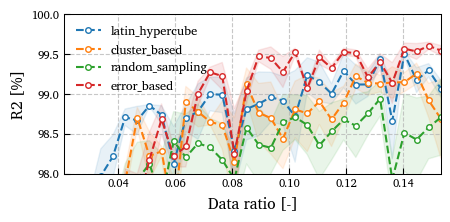

In [41]:
fig, ax = plt.subplots(figsize=plot_params.get_figsize(0.75,0.5))

for j,method in enumerate(['latin_hypercube','cluster_based','random_sampling','error_based']):
    df_method = df_perf_comp_iter[df_perf_comp_iter['method']==method]

    R2_values = np.column_stack(df_method['R2'].values)
    data_ratio = np.column_stack(df_method['data_ratio'].values)

    R2_mean_values = R2_values.mean(axis=1)*100
    R2_std_values = R2_values.std(axis=1)*100

    for i,(mean, std, label) in enumerate(zip([R2_mean_values],
                                              [R2_std_values],
                                              ['R2'])):
        ax.plot(data_ratio[:,0],
                      mean,
                    color=plot_params.morecolors[2*j],
                    marker='o',
                    markersize=4,
                    linestyle='--',
                    markerfacecolor='white',
                    markeredgecolor=plot_params.morecolors[2*j],
                    label=method,
                    zorder=2)
        
        ax.fill_between(data_ratio[:,0],
                             mean-std*1/2,
                             mean+std*1/2,
                             color=plot_params.morecolors[2*j],
                             alpha=0.1,
                             zorder=0)
        
        ax.legend()
        ax.set_ylabel(label)

ax.grid(True, axis='both', linestyle='--', alpha=0.7)
ax.set_xlabel('Data ratio [-]')
ax.set_xlim([min(data_ratio[:,0]), max(data_ratio[:,0])])
plt.ylabel('R2 [%]')
plt.ylim([98,100])

plt.tight_layout()

if plot_params.save_figures:
    plt.savefig(r'Plots\RAL_02.svg', format='svg')

plt.show()

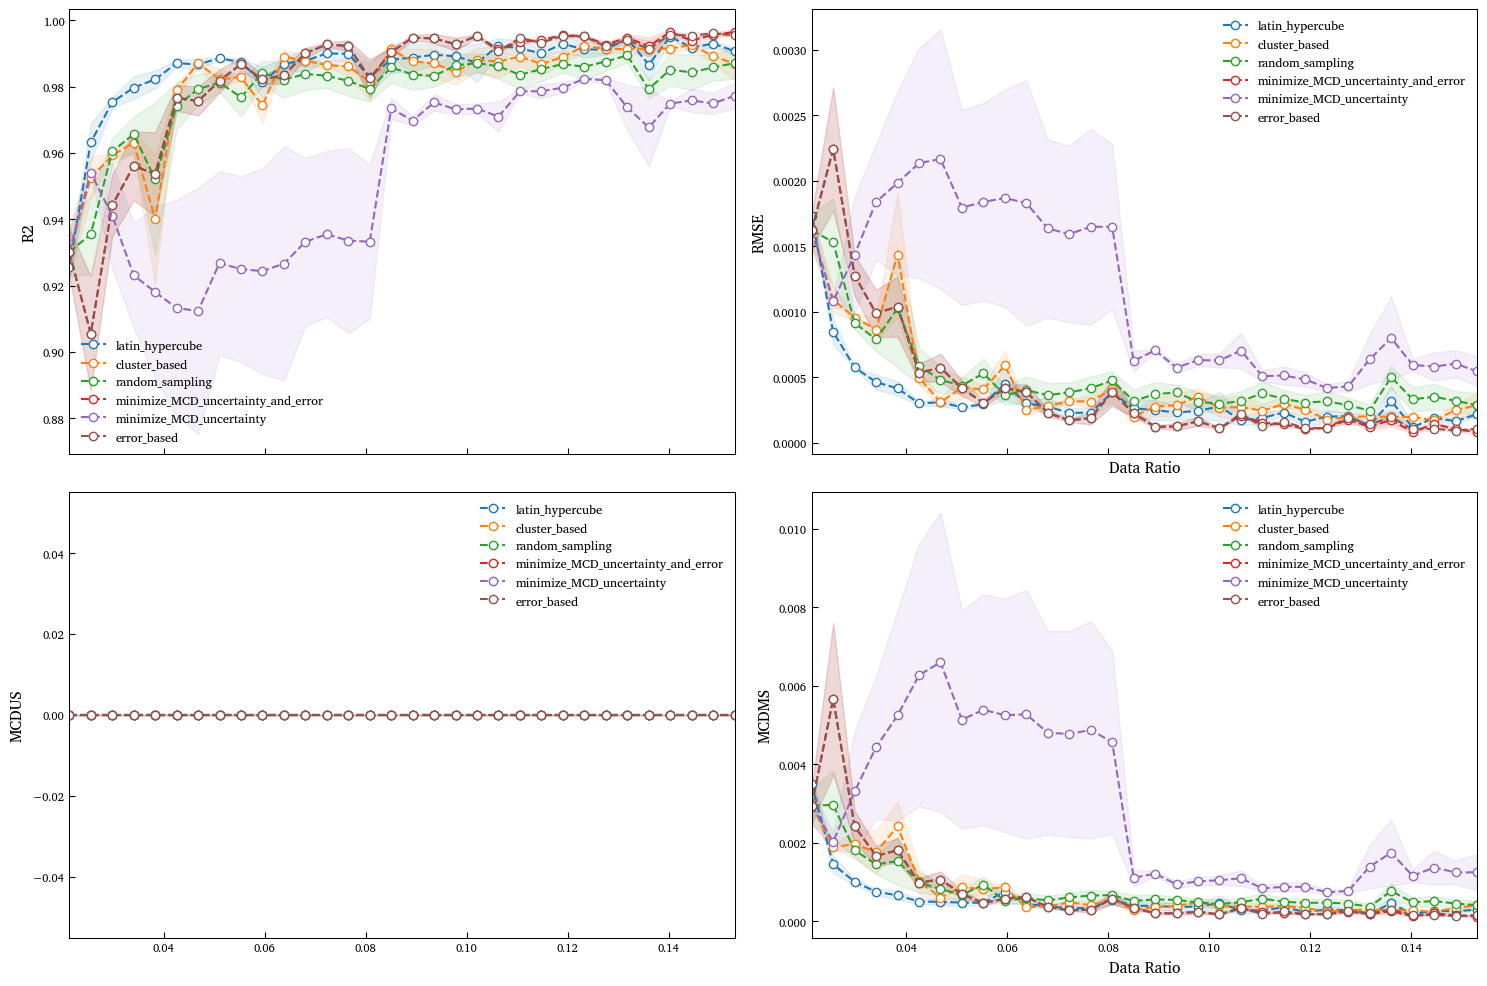

In [6]:
fig, axs = plt.subplots(2,2, figsize=(15,10),sharex=True)

for j,method in enumerate(df_perf_comp_iter['method'].unique()):
    df_method = df_perf_comp_iter[df_perf_comp_iter['method']==method]

    R2_values = np.column_stack(df_method['R2'].values)
    RMSE_values = np.column_stack(df_method['MSE'].values)
    MCDUS_values = np.column_stack(df_method['MCDUS'].values)
    MCDMS_values = np.column_stack(df_method['MCDMS'].values)
    data_ratio = np.column_stack(df_method['data_ratio'].values)

    R2_mean_values = R2_values.mean(axis=1)
    R2_std_values = R2_values.std(axis=1)

    RMSE_mean_values = RMSE_values.mean(axis=1)
    RMSE_std_values = RMSE_values.std(axis=1)

    MCDUS_mean_values = MCDUS_values.mean(axis=1)
    MCDUS_std_values = MCDUS_values.std(axis=1)

    MCDMS_mean_values = MCDMS_values.mean(axis=1)
    MCDMS_std_values = MCDMS_values.std(axis=1)

    for i,(mean, std, label) in enumerate(zip([R2_mean_values, RMSE_mean_values, MCDUS_mean_values, MCDMS_mean_values],
                                              [R2_std_values, RMSE_std_values, MCDUS_std_values, MCDMS_std_values],
                                              ['R2', 'RMSE', 'MCDUS', 'MCDMS'])):
        axs[int(i/2),i%2].plot(data_ratio[:,0],
                      mean,
                    color=plot_params.morecolors[2*j],
                    marker='o',
                    markersize=6,
                    linestyle='--',
                    markerfacecolor='white',
                    markeredgecolor=plot_params.morecolors[2*j],
                    label=method,
                    zorder=2)
        
        axs[int(i/2),i%2].fill_between(data_ratio[:,0],
                             mean-std*1/2,
                             mean+std*1/2,
                             color=plot_params.morecolors[2*j],
                             alpha=0.1,
                             zorder=0)
        
        axs[int(i/2),i%2].legend()
        axs[int(i/2),i%2].set_ylabel(label)

axs[1,1].set_xlabel('Data Ratio')
axs[0,1].set_xlabel('Data Ratio')
axs[0,0].set_xlim([min(data_ratio[:,0]), max(data_ratio[:,0])])

plt.tight_layout()
plt.show()

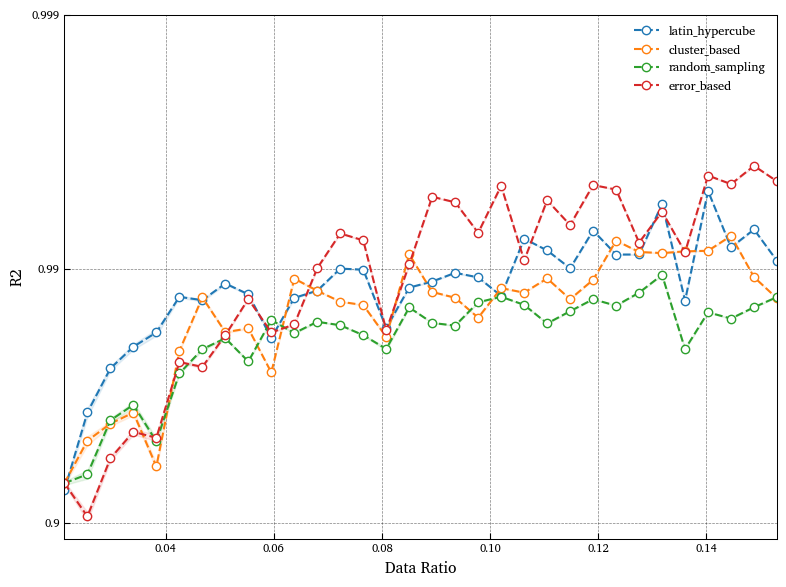

In [22]:
fig, ax = plt.subplots(figsize=(8,6),sharex=True)

for j,method in enumerate(['latin_hypercube','cluster_based','random_sampling','error_based']):
    df_method = df_perf_comp_iter[df_perf_comp_iter['method']==method]

    R2_values = np.column_stack(df_method['R2'].values)
    data_ratio = np.column_stack(df_method['data_ratio'].values)

    R2_mean_values = R2_values.mean(axis=1)
    R2_std_values = R2_values.std(axis=1)

    R2_mean_log = -np.log10(1-R2_mean_values)
    R2_std_log = np.log10(1-R2_mean_values+R2_std_values) - np.log10(1-R2_mean_values-R2_std_values)

    ax.plot(data_ratio[:,0],
                    R2_mean_log,
                color=plot_params.morecolors[2*j],
                marker='o',
                markersize=6,
                linestyle='--',
                markerfacecolor='white',
                markeredgecolor=plot_params.morecolors[2*j],
                label=method,
                zorder=2)
    
    ax.fill_between(data_ratio[:,0],
                            R2_mean_log-std*1/2,
                            R2_mean_log+std*1/2,
                            color=plot_params.morecolors[2*j],
                            alpha=0.1,
                            zorder=0)
    
    ax.legend()
    ax.set_ylabel(label)

ax.set_ylabel('R2')
ax.set_yticks(range(1, 3 + 1), [f"0.{'9' * i}" for i in range(1, 4)])
ax.legend()
ax.grid(True, which='major', color='k', linestyle='--', linewidth=0.5, alpha=0.5)

ax.set_xlabel('Data Ratio')
ax.set_xlabel('Data Ratio')
ax.set_xlim([min(data_ratio[:,0]), max(data_ratio[:,0])])

plt.tight_layout()
plt.show()

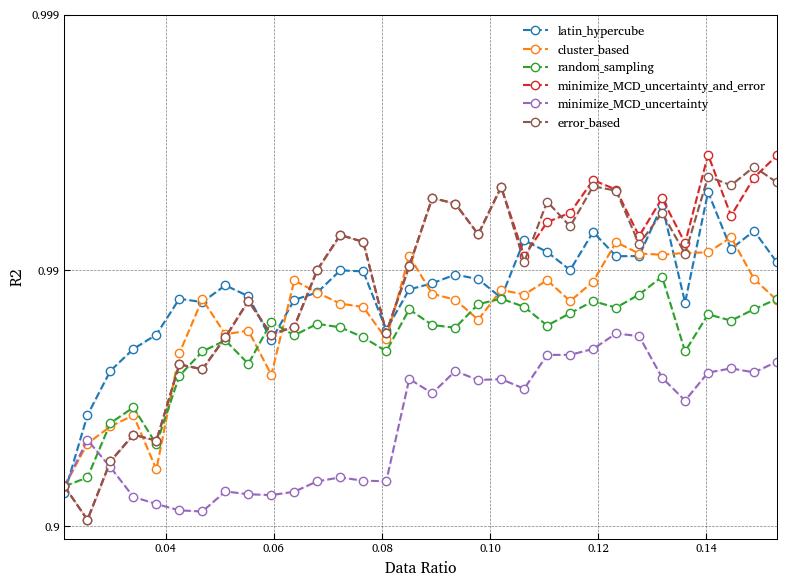

In [7]:
fig, ax = plt.subplots(figsize=(8,6),sharex=True)

for j,method in enumerate(df_perf_comp_iter['method'].unique()):
    df_method = df_perf_comp_iter[df_perf_comp_iter['method']==method]

    R2_values = np.column_stack(df_method['R2'].values)
    data_ratio = np.column_stack(df_method['data_ratio'].values)

    R2_mean_values = R2_values.mean(axis=1)
    R2_std_values = R2_values.std(axis=1)

    R2_mean_log = -np.log10(1-R2_mean_values)
    R2_std_log = np.log10(1-R2_mean_values+R2_std_values) - np.log10(1-R2_mean_values-R2_std_values)

    ax.plot(data_ratio[:,0],
                    R2_mean_log,
                color=plot_params.morecolors[2*j],
                marker='o',
                markersize=6,
                linestyle='--',
                markerfacecolor='white',
                markeredgecolor=plot_params.morecolors[2*j],
                label=method,
                zorder=2)
    
    ax.fill_between(data_ratio[:,0],
                            R2_mean_log-std*1/2,
                            R2_mean_log+std*1/2,
                            color=plot_params.morecolors[2*j],
                            alpha=0.1,
                            zorder=0)
    
    ax.legend()
    ax.set_ylabel(label)

ax.set_ylabel('R2')
ax.set_yticks(range(1, 3 + 1), [f"0.{'9' * i}" for i in range(1, 4)])
ax.legend()
ax.grid(True, which='major', color='k', linestyle='--', linewidth=0.5, alpha=0.5)

ax.set_xlabel('Data Ratio')
ax.set_xlabel('Data Ratio')
ax.set_xlim([min(data_ratio[:,0]), max(data_ratio[:,0])])

plt.tight_layout()
plt.show()

## Methods Comparison with Fine Tuning

In [107]:
activeLearning = AL(model = model,
              method = None,
              df = df
            )

activeLearning.batch_size = 100
activeLearning.n_init_samples = 1000
activeLearning.config['init_strategy'] = 'latin_hypercube'
activeLearning.config['stopping_criteria'] = None
activeLearning.config['stopping_threshold'] = 1.0
activeLearning.config['selection_mode'] = 'fixed_batch'

** Available Methods **
error_based
minimize_MCD_uncertainty
minimize_MCD_uncertainty_and_error
random_sampling
cluster_based
latin_hypercube
** Available Initiation Methods **
kmeans
latin_hypercube
max_min_distance
random_sampling


In [108]:
df_initial = activeLearning.select_initial_data()

In [109]:
methods_to_test = activeLearning.methods_available

In [110]:
max_iterations = 20
initial_epochs = 100
added_data_epochs_ratio = 2

In [111]:
model = DNN()

# Copy the model parameters from the benchmark model to the test model
for line in model_benchmark.config:
    model.config[line] = model_benchmark.config[line]

for line in model_benchmark.data:
    model.data[line] = model_benchmark.data[line]

model.features = model_benchmark.features
model.target = model_benchmark.target

# Adjust epochs and learning rate
model.config['epochs'] = initial_epochs
model.config['learning_rate'] = 0.01
model.config['dropout_prob'] = 0.00
model.config['print_logs'] = False

In [112]:
performance = {'method':[], 'data_ratio': [], 'data_indeces': [], 'epoch': [],
               'MSE': [], 'RMSE': [], 'MAE': [], 'R2': [], 'MCDMS': [], 'MCDUS': []}

df_train = df_initial.copy()
df_remaining = df.drop(df_train.index)

model.prepare_data(df_train)
model.build()
model.train()

# Initial metrics
metrics = model.get_metrics()

# Update log
performance['data_ratio'].append(len(df_train) / len(df))
performance['method'].append('Initial')
performance['data_indeces'].append(df_train.index.tolist())  
performance['epoch'].append(initial_epochs)  

for metric in metrics:
    performance[metric].append(metrics[metric])

print(f"Initial R² Score: {metrics['R2']}")

for method in methods_to_test:
    print(f"**** Current method: {method} ****")
    model_sim = copy.deepcopy(model)
    df_train = df_initial.copy()
    df_remaining = df.drop(df_train.index)

    for i in range(max_iterations+1):

        print(f"Iteration {i + 1}: Training with {len(df_train)} samples")

        df_new, df_remaining = activeLearning.select_method(method, model_sim, df_remaining)
        if df_new is None:
            print("No new samples selected. Stopping.")
            break

        df_train = pd.concat([df_train, df_new])

        # Fine Tune Epoch proportional to the number added samples
        fine_tune_epochs = int(len(df_new)/added_data_epochs_ratio)
        print(f"Fine-tuning for {fine_tune_epochs} epochs")

        model_sim.fine_tune(df_new, epochs=fine_tune_epochs)

        # Evaluate model performance.
        model_sim.dropout.p = 0.1
        metrics = model_sim.get_metrics()
        model_sim.dropout.p = model.config['dropout_prob']

        # Update log
        performance['data_ratio'].append(len(df_train) / len(df))
        performance['method'].append(method)
        performance['data_indeces'].append(df_train.index.tolist()) 
        performance['epoch'].append(fine_tune_epochs)
        for metric in metrics:
            performance[metric].append(metrics[metric])
        print(f"    R² Score: {metrics['R2']}")

Initial R² Score: 0.8761361017823219
**** Current method: error_based ****
Iteration 1: Training with 1000 samples
Fine-tuning for 50 epochs
    R² Score: 0.9022779315710068
Iteration 2: Training with 1100 samples
Fine-tuning for 50 epochs
    R² Score: 0.9420428313314915
Iteration 3: Training with 1200 samples
Fine-tuning for 50 epochs
    R² Score: 0.9611921906471252
Iteration 4: Training with 1300 samples
Fine-tuning for 50 epochs
    R² Score: 0.9618120640516281
Iteration 5: Training with 1400 samples
Fine-tuning for 50 epochs
    R² Score: 0.9658400528132915
Iteration 6: Training with 1500 samples
Fine-tuning for 50 epochs
    R² Score: 0.9709853008389473
Iteration 7: Training with 1600 samples
Fine-tuning for 50 epochs
    R² Score: 0.9844847284257412
Iteration 8: Training with 1700 samples
Fine-tuning for 50 epochs
    R² Score: 0.9796677064150572
Iteration 9: Training with 1800 samples
Fine-tuning for 50 epochs
    R² Score: 0.981059392914176
Iteration 10: Training with 1900 sa

In [113]:
df_performance = pd.DataFrame(performance)

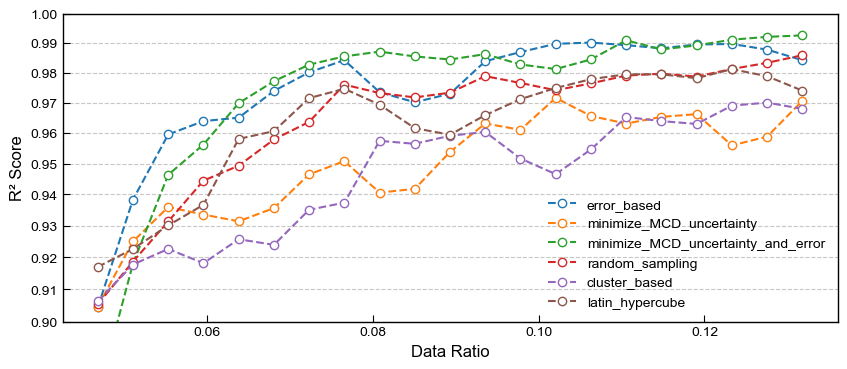

In [124]:
from scipy.signal import savgol_filter

fig, ax = plt.subplots(figsize=(10, 4))

for i, method in enumerate(methods_to_test):
    df_method = df_performance[df_performance['method'] == method]

    R2_values = df_method['R2'].values
    data_ratio = df_method['data_ratio'].values

    sort_idx = data_ratio.argsort()
    data_ratio_sorted = data_ratio[sort_idx]
    R2_sorted = R2_values[sort_idx]

    R2_smoothed = savgol_filter(R2_sorted, window_length=5, polyorder=2)

    plt.semilogy(data_ratio_sorted,
                 R2_smoothed,
                 color=plot_params.colors[i],
                 marker='o',
                 markersize=6,
                 linestyle='--',
                 markerfacecolor='white',
                 markeredgecolor=plot_params.colors[i],
                 label=method,
                 zorder=2)

plt.legend()
plt.ylim([0.9, 1])
plt.yticks(np.arange(0.9, 1.01, 0.01), [f"{i:.2f}" for i in np.arange(0.9, 1.01, 0.01)])
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.ylabel('R² Score')
plt.xlabel('Data Ratio')
plt.show()


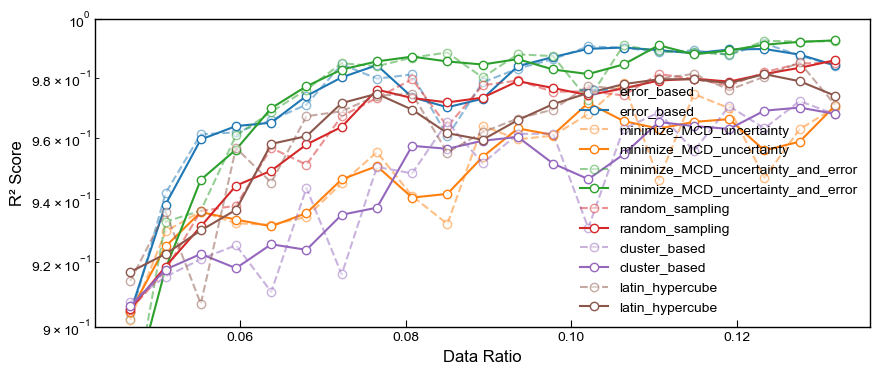

In [127]:
fig, ax = plt.subplots(figsize=(10, 4))

for i,method in enumerate(methods_to_test):
    df_method = df_performance[df_performance['method']==method]

    R2_values = df_method['R2'].values
    data_ratio = df_method['data_ratio'].values
    epochs = df_method['epoch'].values
    
    plt.semilogy(data_ratio,
            R2_values,
            color=plot_params.colors[i],
            marker='o',
            markersize=6,
            linestyle='--',
            markerfacecolor='white',
            markeredgecolor=plot_params.colors[i],
            label=method,
            alpha=0.5,
            zorder=2)
    
    sort_idx = data_ratio.argsort()
    data_ratio_sorted = data_ratio[sort_idx]
    R2_sorted = R2_values[sort_idx]
    R2_smoothed = savgol_filter(R2_sorted, window_length=5, polyorder=2)

    plt.semilogy(data_ratio_sorted,
                 R2_smoothed,
                 color=plot_params.colors[i],
                 marker='o',
                 markersize=6,
                 markerfacecolor='white',
                 markeredgecolor=plot_params.colors[i],
                 label=method,
                 zorder=2)

plt.legend()
plt.ylim([0.9,1])
plt.ylabel('R² Score')
plt.xlabel('Data Ratio')


plt.show()